This notebook shows you how to visualize the changes in ozone and particulate matter from different runs of CCTM. Note that you must first run the `combine` program distributed with CMAQ for the files here to exist. The need for postprocessing of CCTM outputs is explained in [this section](https://github.com/USEPA/CMAQ/blob/main/DOCS/Users_Guide/CMAQ_UG_ch08_analysis_tools.md#82-aggregating-and-transforming-model-species) of the CMAQ User's Guide.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from cmaqpy.runcmaq import CMAQModel

import monet as m
import monetio as mio

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


Please install s3fs if retrieving from the Amazon S3 Servers.  Otherwise continue with local data
Please install h5netcdf to open files from the Amazon S3 servers.


In [2]:
# Specify the start/end times
start_datetime = 'August 06, 2016'  # first day that you want run
end_datetime = 'August 14, 2016'  # last day you want run
# Define the coordinate name (must match that in GRIDDESC)
coord_name = 'LAM_40N97W'
# Create a CMAQModel object
base_sim = CMAQModel(start_datetime, end_datetime, '2016Base_12OTC2', coord_name, '12OTC2', verbose=True)
s0_sim = CMAQModel(start_datetime, end_datetime, '2016_12OTC2', coord_name, '12OTC2', verbose=True)

Application name: 2016Base_12OTC2
Coordinate name: LAM_40N97W
Grid name: 12OTC2
CCTM RUNID: v533_gcc9.3.1_2016Base_12OTC2
CMAQ run starting on: 2016-08-06 00:00:00
CMAQ run ending on: 2016-08-14 00:00:00
Application name: 2016_12OTC2
Coordinate name: LAM_40N97W
Grid name: 12OTC2
CCTM RUNID: v533_gcc9.3.1_2016_12OTC2
CMAQ run starting on: 2016-08-06 00:00:00
CMAQ run ending on: 2016-08-14 00:00:00


In [3]:
conc_base = f'{base_sim.POST}/COMBINE_ACONC_{base_sim.cctm_runid}_201608.nc'
conc_s0 = f'{s0_sim.POST}/COMBINE_ACONC_{s0_sim.cctm_runid}_201608.nc'
c = mio.cmaq.open_dataset(fname=conc_base)
c1 = mio.cmaq.open_dataset(fname=conc_s0)

<xarray.Dataset>
Dimensions:        (COL: 273, DATE-TIME: 2, LAY: 1, ROW: 246, TSTEP: 192, VAR: 134)
Dimensions without coordinates: COL, DATE-TIME, LAY, ROW, TSTEP, VAR
Data variables: (12/143)
    TFLAG          (TSTEP, VAR, DATE-TIME) int32 ...
    AIR_DENS       (TSTEP, LAY, ROW, COL) float32 ...
    RH             (TSTEP, LAY, ROW, COL) float32 ...
    SFC_TMP        (TSTEP, LAY, ROW, COL) float32 ...
    PBLH           (TSTEP, LAY, ROW, COL) float32 ...
    SOL_RAD        (TSTEP, LAY, ROW, COL) float32 ...
    ...             ...
    CAf            (TSTEP, LAY, ROW, COL) float32 0.01152 0.01227 ... 0.01456
    NOy            (TSTEP, LAY, ROW, COL) float32 0.5959 0.5335 ... 0.3441
    NOx            (TSTEP, LAY, ROW, COL) float32 0.328 0.2736 ... 0.1247
    NO3f           (TSTEP, LAY, ROW, COL) float32 0.05763 0.06108 ... 0.009817
    NH4f           (TSTEP, LAY, ROW, COL) float32 0.001859 0.001269 ... 0.000772
    SO4f           (TSTEP, LAY, ROW, COL) float32 0.008773 0.009498 ...

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


<GeoAxesSubplot:title={'center':'time = 2016-08-07T23:00:00'}, xlabel='longitude', ylabel='latitude'>

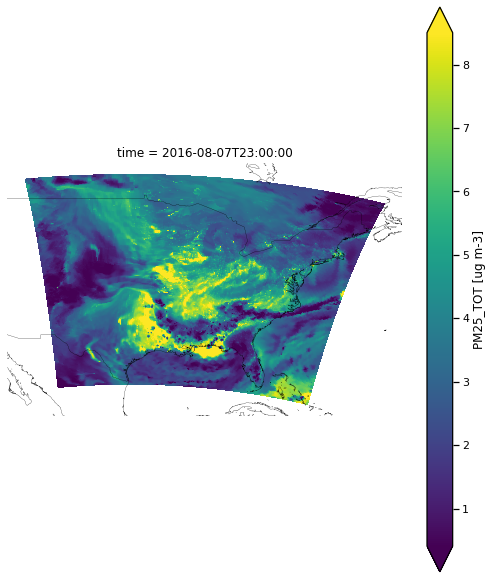

In [4]:
# If you just want to do a quick map visualization
c.PM25_TOT.sel(time='2016-08-07 23').monet.quick_map(robust=True)

In [5]:
def pollution_plot(da, vmin=0, vmax=12, cmap=cm.get_cmap('YlOrBr'), 
                   extent=None,
                   cbar_label='PM$_{2.5}$ ($\mu g/m^{3}$)', titlestr='Title', savefig=False, figpath='./pollution_plot.png'):
    # This creates a more involved plot
    if extent is None:
        extent = [da.longitude.min(), da.longitude.max(), da.latitude.min(), da.latitude.max() - 2]
    ax = m.plots.draw_map(states=True, resolution='10m',  linewidth=0.5, figsize=(15,7), extent=extent, subplot_kw={'projection': ccrs.PlateCarree()})
    p = da.plot(x='longitude', y='latitude', ax=ax, robust=True, 
                vmin=vmin, vmax=vmax, cmap=cmap,
                cbar_kwargs={'label': cbar_label},
                )
    if titlestr is not None:
        ax.set_title(titlestr)
    if savefig:
        plt.savefig(figpath)
    else:
        plt.show()

In [6]:
def conc_compare(da1, da2, extent=None,
                 vmin1=0, vmax1=10, vmin2=-1, vmax2=1, cmap1=cm.get_cmap('YlOrBr'), cmap2=cm.get_cmap('bwr'),
                 cbar_label1='PM$_{2.5}$ ($\mu g/m^{3}$)', cbar_label2='PM$_{2.5}$ Difference (%)',
                 titlestr1=None, titlestr2=None,
                 figsize=(15,7), savefig=False, figpath1='./conc_compare1.png', figpath2='./conc_compare2.png'):
    """
    Creates two filled colormaps for concentration comparisons.
    """
    # f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=fsize)
    if extent is None:
        extent = [da1.longitude.min(), da1.longitude.max(), da1.latitude.min(), da1.latitude.max() - 2]
    f1, ax1 = m.plots.draw_map(states=True, resolution='10m', figsize=figsize,  linewidth=0.5, extent=extent, subplot_kw={'projection': ccrs.PlateCarree()}, return_fig=True)
    f2, ax2 = m.plots.draw_map(states=True, resolution='10m', figsize=figsize,  linewidth=0.5,  extent=extent, subplot_kw={'projection': ccrs.PlateCarree()}, return_fig=True)
    # f.axes.append(ax2)
    da1.plot(x='longitude', y='latitude', ax=ax1, robust=True, 
            vmin=vmin1, vmax=vmax1, cmap=cmap1,
            cbar_kwargs={'label': cbar_label1},
            )
    da2.plot(x='longitude', y='latitude', ax=ax2, robust=True, 
            vmin=vmin2, vmax=vmax2, cmap=cmap2,
            cbar_kwargs={'label': cbar_label2},
            )

    if titlestr1 is not None:
        ax1.set_title(titlestr1)
    if titlestr2 is not None:
        ax2.set_title(titlestr2)
    if savefig:
        f1.savefig(figpath1, dpi=300, transparent=True, bbox_inches='tight')
        f2.savefig(figpath2, dpi=300, transparent=True, bbox_inches='tight')
    else:
        f1.show()
        f2.show()

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


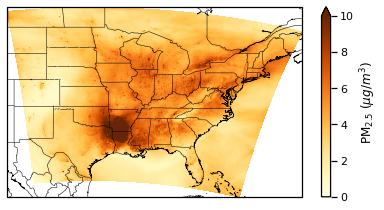

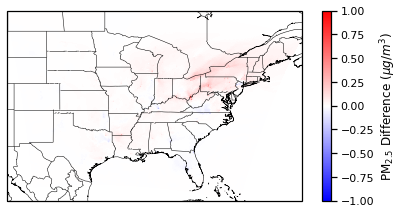

In [45]:
pm25_mean = c1.PM25_TOT.mean(dim='time')
pm25_mean_diff = (c1.PM25_TOT - c.PM25_TOT).mean(dim='time')
# pm25_pct_diff = (c1.PM25_TOT - c.PM25_TOT) / c.PM25_TOT
# pm25_mean_pct_diff = pm25_pct_diff.mean(dim='time')

conc_compare(pm25_mean, pm25_mean_diff, extent=None,
             vmin1=0, vmax1=10, vmin2=-1, vmax2=1, cmap1=cm.get_cmap('YlOrBr'), cmap2=cm.get_cmap('bwr'),
             cbar_label1='PM$_{2.5}$ ($\mu g/m^{3}$)', cbar_label2='PM$_{2.5}$ Difference ($\mu g/m^{3}$)',
             figsize=(7,3.5), savefig=True, figpath1='../cmaqpy/data/plots/PM2.5.png', 
             figpath2='../cmaqpy/data/plots/PM2.5_diff.png')

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


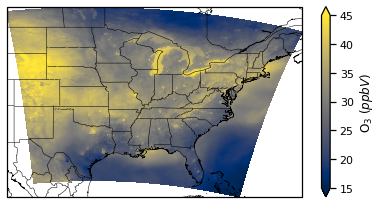

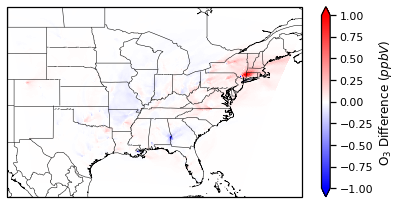

In [48]:
o3_mean = c1.O3.mean(dim='time')
o3_mean_diff = (c1.O3 - c.O3).mean(dim='time')
# o3_pct_diff = (c1.O3 - c.O3) / c.O3
# o3_mean_pct_diff = o3_pct_diff.mean(dim='time')

conc_compare(o3_mean, o3_mean_diff, extent=None,
             vmin1=15, vmax1=45, vmin2=-1, vmax2=1, cmap1=cm.get_cmap('cividis'), cmap2=cm.get_cmap('bwr'),
             cbar_label1='O$_{3}$ ($ppbV$)', cbar_label2='O$_{3}$ Difference ($ppbV$)',
             figsize=(7,3.5), savefig=True, figpath1='../cmaqpy/data/plots/O3.png', 
             figpath2='../cmaqpy/data/plots/O3_diff.png')

In [8]:
%%capture
# This plots the difference in PM for each time slice
for ts in c.time:
    tstr = ts.dt.strftime("%Y-%m-%d %H:%M").values
    ts = ts.values
    pm25_conc = c1.PM25_TOT.sel(time=ts)
    pm25_diff = c1.PM25_TOT.sel(time=ts) - c.PM25_TOT.sel(time=ts)

    conc_compare(pm25_conc, pm25_diff, extent=None,
                vmin1=0, vmax1=10, vmin2=-1, vmax2=1, cmap1=cm.get_cmap('YlOrBr'), cmap2=cm.get_cmap('bwr'),
                cbar_label1='PM$_{2.5}$ ($\mu g/m^{3}$)', cbar_label2='PM$_{2.5}$ Difference ($\mu g/m^{3}$)',
                titlestr1=tstr, titlestr2=tstr,
                savefig=True, figpath1=f'../cmaqpy/data/plots/PM25_{tstr}.png', 
                figpath2=f'../cmaqpy/data/plots/PM25_diff_{tstr}.png')

In [8]:
%%capture
# This plots the difference in O3 for each time slice
for ts in c.time:
    tstr = ts.dt.strftime("%Y-%m-%d %H:%M").values
    ts = ts.values
    o3_conc = c1.O3.sel(time=ts)
    o3_diff = (c1.O3 - c.O3).sel(time=ts)

    conc_compare(o3_conc, o3_diff, extent=None,
                vmin1=15, vmax1=45, vmin2=-1, vmax2=1, cmap1=cm.get_cmap('cividis'), cmap2=cm.get_cmap('bwr'),
                cbar_label1='O$_{3}$ ($ppbV$)', cbar_label2='O$_{3}$ Difference ($ppbV$)',
                titlestr1=tstr, titlestr2=tstr,
                savefig=True, figpath1=f'../cmaqpy/data/plots/O3_{tstr}.png', 
                figpath2=f'../cmaqpy/data/plots/O3_diff_{tstr}.png')

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


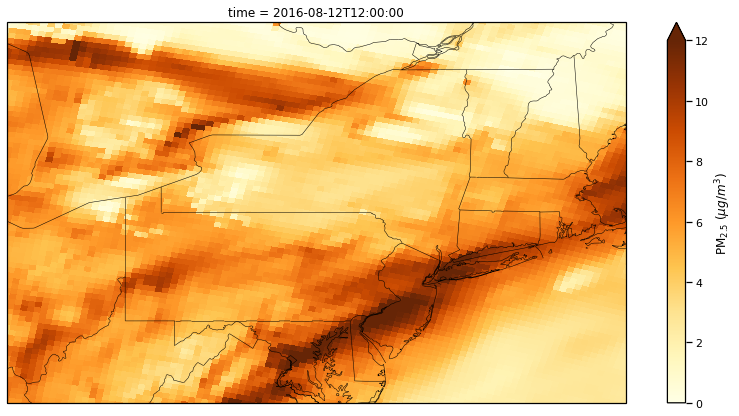

In [20]:
# This creates a more involved plot
pm25_now = c.PM25_TOT.sel(time='2016-08-12 12:00')
pollution_plot(pm25_now, vmin=0, vmax=12, cmap=cm.get_cmap('YlOrBr'),
               extent = [-83, -70, 38, 46],
               cbar_label='PM$_{2.5}$ ($\mu g/m^{3}$)', 
               titlestr=None, savefig=False, figpath='./pollution_plot.png')

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


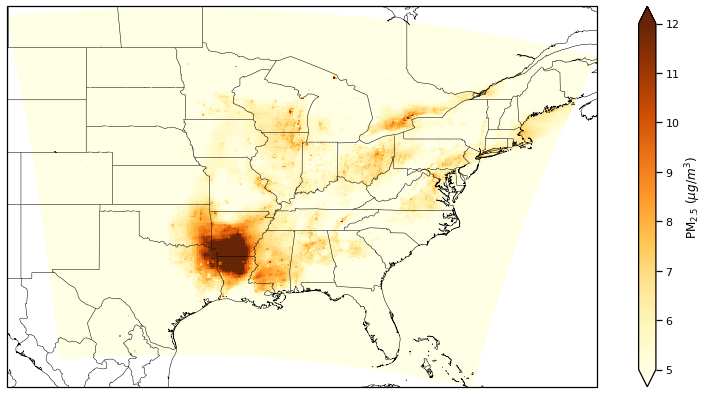

In [8]:
# Produce a mean plot for PM2.5
pollution_plot(c.PM25_TOT.mean(dim='time'), vmin=5, vmax=12, cmap=cm.get_cmap('YlOrBr'), cbar_label='PM$_{2.5}$ ($\mu g/m^{3}$)', 
               titlestr=None, savefig=False, figpath='./pollution_plot.png')

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


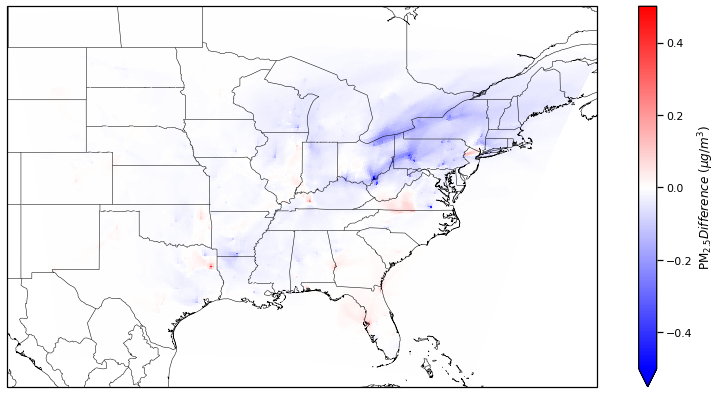

In [9]:
# Look at the mean differences in PM2.5
pm25_diff = c.PM25_TOT.mean(dim='time') - c1.PM25_TOT.mean(dim='time')
pollution_plot(pm25_diff, vmin=-0.5, vmax=0.5, cmap=cm.get_cmap('bwr'), cbar_label='PM$_{2.5} Difference$ ($\mu g/m^{3}$)', 
               titlestr=None, savefig=False, figpath='./pollution_plot.png')

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


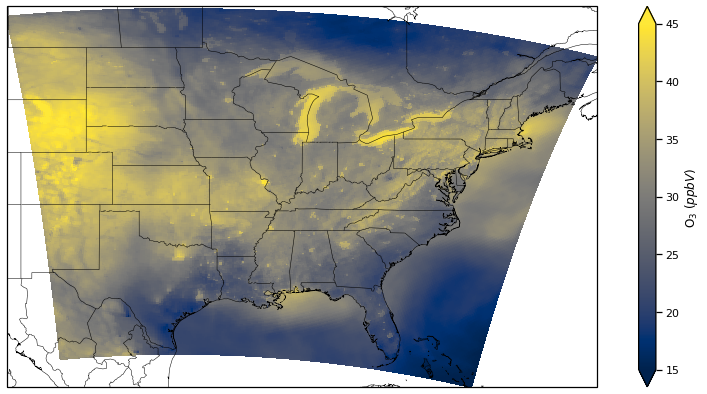

In [53]:
# Produce a mean plot for O3
pollution_plot(c.O3.mean(dim='time'), vmin=15, vmax=45, cmap=cm.get_cmap('cividis'), cbar_label='O$_3$ ($ppbV$)', 
               titlestr=None, savefig=False, figpath='./pollution_plot.png')

/home/jas983/anaconda3/envs/oshwind/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


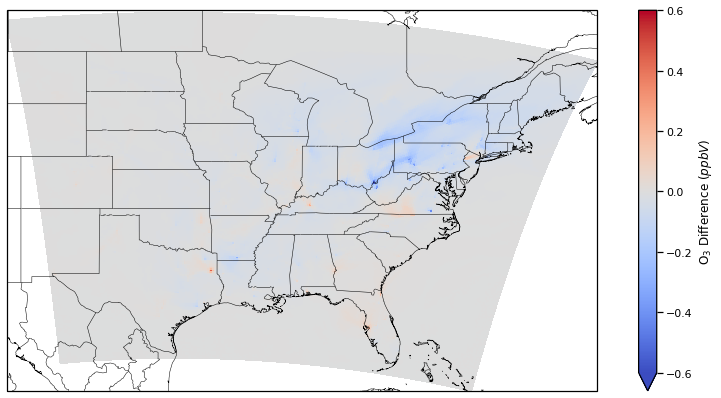

In [64]:
# Look at the mean differences in O3
o3_diff = c.PM25_TOT.mean(dim='time') - c1.PM25_TOT.mean(dim='time')
pollution_plot(o3_diff, vmin=-0.6, vmax=0.6, cmap=cm.get_cmap('coolwarm'), cbar_label='O$_3$ Difference ($ppbV$)', 
               titlestr=None, savefig=False, figpath='./pollution_plot.png')

In [7]:
# Open the output files
aconc_base_df = xr.open_dataset(f'{base_sim.POST}/COMBINE_ACONC_{base_sim.cctm_runid}_201608.nc')
aconc_s0_df = xr.open_dataset(f'{s0_sim.POST}/COMBINE_ACONC_{s0_sim.cctm_runid}_201608.nc')

In [8]:
aconc_base_df

<xarray.Dataset>
Dimensions:        (COL: 273, DATE-TIME: 2, LAY: 1, ROW: 246, TSTEP: 192, VAR: 134)
Dimensions without coordinates: COL, DATE-TIME, LAY, ROW, TSTEP, VAR
Data variables: (12/135)
    TFLAG          (TSTEP, VAR, DATE-TIME) int32 ...
    AIR_DENS       (TSTEP, LAY, ROW, COL) float32 ...
    RH             (TSTEP, LAY, ROW, COL) float32 ...
    SFC_TMP        (TSTEP, LAY, ROW, COL) float32 ...
    PBLH           (TSTEP, LAY, ROW, COL) float32 ...
    SOL_RAD        (TSTEP, LAY, ROW, COL) float32 ...
    ...             ...
    PM25_NO3_loss  (TSTEP, LAY, ROW, COL) float32 ...
    ANO3IJ_loss    (TSTEP, LAY, ROW, COL) float32 ...
    PM25_NH4_loss  (TSTEP, LAY, ROW, COL) float32 ...
    ANH4IJ_loss    (TSTEP, LAY, ROW, COL) float32 ...
    PMIJ_FRM       (TSTEP, LAY, ROW, COL) float32 ...
    PM25_FRM       (TSTEP, LAY, ROW, COL) float32 ...
Attributes: (12/33)
    IOAPI_VERSION:  ioapi-3.2: $Id: init3.F90 200 2021-05-10 14:06:20Z coats ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2022077
    CTIME:          20212
    WDATE:          2022077
    ...             ...
    VGLVLS:         [1.     0.9975]
    GDNAM:          12OTC2          
    UPNAM:          COMBINE         
    VAR-LIST:       AIR_DENS        RH              SFC_TMP         PBLH     ...
    FILEDESC:       Concentration file output                                ...
    HISTORY:

In [11]:
stand_lon = aconc_base_df.XCENT
moad_cen_lat = aconc_base_df.YCENT
truelat1 = aconc_base_df.P_ALP
truelat2 = aconc_base_df.P_BET
if aconc_base_df.GDTYP == 2:
    wrf_cartopy_crs = ccrs.LambertConformal(central_longitude=stand_lon,
                                            central_latitude=moad_cen_lat,
                                            standard_parallels=[truelat1, truelat2])

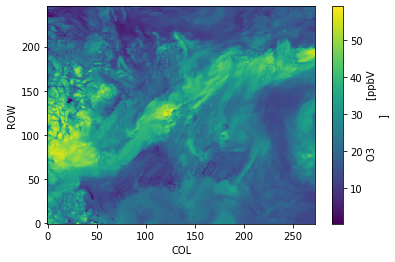

In [15]:
# Visualize the Ozone
aconc_base_df.O3.sel(TSTEP=180).plot()

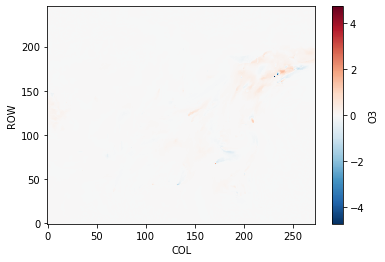

In [16]:
(aconc_s0_df.O3.sel(TSTEP=180) - aconc_base_df.O3.sel(TSTEP=180)).plot()

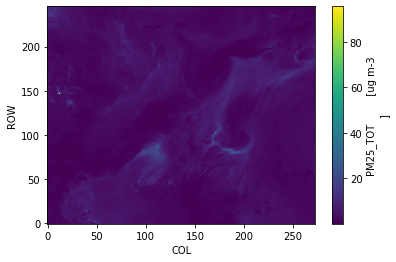

In [20]:
# Visualize the PM25_TOT
aconc_base_df.PM25_TOT.sel(TSTEP=180).plot()

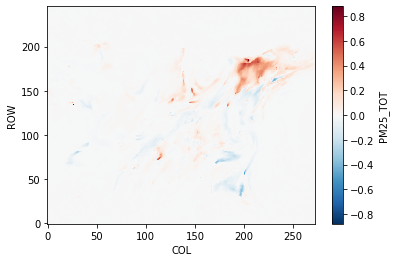

In [21]:
(aconc_s0_df.PM25_TOT.sel(TSTEP=180) - aconc_base_df.PM25_TOT.sel(TSTEP=180)).plot()